<center><h1><b>Baseline: SARIMAX</b></h1></center>

In [27]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import seaborn as sns

In [21]:
df = pd.read_csv("Processed Datasets/Crime_Weather_Dataset.csv", parse_dates=["Date"])

# Check structure
print(df.shape)
print(df.columns)
print(df["Date"].min(), "to", df["Date"].max())
print("Number of boroughs:", df["Borough"].nunique())

(7111, 14)
Index(['Date', 'Borough', 'Burglary', 'Robbery', 'Theft', 'Total_Crime',
       'tempmax', 'tempmin', 'temp', 'humidity', 'precip', 'snow', 'windspeed',
       'visibility'],
      dtype='object')
2019-01-01 00:00:00 to 2020-06-30 00:00:00
Number of boroughs: 13


In [22]:
# Define features and containers
# Generate lag features
#df["lag_1"] = df.groupby("Borough")["Total_Crime"].shift(1)
#df["lag_7"] = df.groupby("Borough")["Total_Crime"].shift(7)

# Generate day-of-week one-hot encoding
#df["day_of_week"] = df["Date"].dt.dayofweek  # Monday=0, Sunday=6
#df = pd.get_dummies(df, columns=["day_of_week"], drop_first=True)

# Drop rows with missing lag values
#df.dropna(subset=["lag_1", "lag_7"], inplace=True)

# Create features list
#features = ["temp", "humidity", "precip", "windspeed", "lag_1", "lag_7"]
#features += [col for col in df.columns if col.startswith("day_of_week_")]
features = ["temp", "humidity", "precip", "windspeed"]

# Get unique boroughs
boroughs = df["Borough"].unique()

# Prepare result containers
metrics = []
all_predictions = []

In [23]:
# Define custom SARIMAX parameters for each borough
param_dict = {
    'Tower Hamlets': ((1, 1, 1), (0, 1, 1, 7)),
    'Greenwich': ((1, 1, 2), (1, 0, 1, 7)),
    'Lewisham': ((2, 1, 1), (0, 1, 1, 7)),
    'Hammersmith and Fulham': ((1, 1, 2), (1, 1, 0, 7)),
    'City of London': ((0, 1, 1), (1, 0, 1, 7)),
    'Wandsworth': ((2, 1, 1), (1, 1, 1, 7)),
    'Southwark': ((2, 1, 0), (1, 1, 1, 7)),
    'Islington': ((1, 1, 2), (0, 1, 1, 7)),
    'Hackney': ((2, 1, 2), (1, 0, 1, 7)),
    'Lambeth': ((1, 1, 1), (1, 1, 0, 7)),
    'Camden': ((2, 1, 1), (1, 1, 1, 7)),
    'Kensington and Chelsea': ((1, 1, 1), (0, 1, 1, 7)),
    'Westminster': ((1, 1, 1), (1, 1, 1, 30)),
}

In [24]:
# Collect borough names
# boroughs = df["Borough"].unique()
# metrics = []
# all_predictions = []

# for borough in boroughs:
#     print(f"\nProcessing {borough}...")

#     df_b = df[df["Borough"] == borough].copy()
#     df_b = df_b.sort_values("Date").reset_index(drop=True)

#     # Split
#     train = df_b[(df_b["Date"] >= "2019-01-01") & (df_b["Date"] <= "2019-12-31")]
#     test = df_b[(df_b["Date"] >= "2020-04-01") & (df_b["Date"] <= "2020-04-14")]

#     train_y = train["Total_Crime"]
#     test_y = test["Total_Crime"]
#     train_X = train[features]
#     test_X = test[features]

#     # Clean: drop NaNs and ensure float
#     train_X = train_X.dropna()
#     train_y = train_y.loc[train_X.index]

#     train_X = train_X.select_dtypes(include=[np.number]).astype(float)
#     train_y = train_y.astype(float)

#     test_X = test_X.select_dtypes(include=[np.number]).astype(float)
#     test_y = test_y.astype(float)

#     # Lookup parameters from dict
#     if borough in param_dict:
#         order, seasonal_order = param_dict[borough]
#         print(f"Using order={order}, seasonal_order={seasonal_order}")
#     else:
#         print(f"WARNING: '{borough}' not in param_dict. Using default.")
#         order, seasonal_order = (1, 1, 1), (1, 1, 1, 7)

#     # SARIMAX model
#     try:
#         model = SARIMAX(train_y,
#                         exog=train_X,
#                         order=order,
#                         seasonal_order=seasonal_order,
#                         enforce_stationarity=False,
#                         enforce_invertibility=False)
#         results = model.fit(disp=False)

#         # Forecast
#         forecast = results.get_forecast(steps=len(test_y), exog=test_X)
#         predicted = forecast.predicted_mean

#         # Evaluation
#         mae = mean_absolute_error(test_y, predicted)
#         rmse = mean_squared_error(test_y, predicted, squared=False)
#         metrics.append((borough, mae, rmse))

#         # Save for plotting
#         all_predictions.append({
#             "borough": borough,
#             "dates": test["Date"].values,
#             "actual": test_y.values,
#             "predicted": predicted.values
#         })

#     except Exception as e:
#         print(f"Error processing {borough}: {e}")
#         continue

for borough in boroughs:
    print(f"\nProcessing {borough}...")

    df_b = df[df["Borough"] == borough].copy()
    df_b = df_b.sort_values("Date").reset_index(drop=True)

    # Split
    train = df_b[(df_b["Date"] >= "2019-01-01") & (df_b["Date"] <= "2019-12-31")]
    test = df_b[(df_b["Date"] >= "2020-04-01") & (df_b["Date"] <= "2020-04-14")]

    train_y = train["Total_Crime"]
    test_y = test["Total_Crime"]
    train_X = train[features]
    test_X = test[features]

    # Auto ARIMA to select best order/seasonal_order
    print("  Fitting auto_arima (this may take a moment)...")
    stepwise_model = auto_arima(
        train_y,
        exogenous=train_X,
        seasonal=True,
        m=7,  # weekly seasonality
        trace=False,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True,
        n_jobs=-1
    )
    order = stepwise_model.order
    seasonal_order = stepwise_model.seasonal_order
    print(f"  Best order: {order}, seasonal_order: {seasonal_order}")

    # Fit SARIMAX model using selected parameters
    model = SARIMAX(
        train_y,
        exog=train_X,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)

    # Forecast
    forecast = results.get_forecast(steps=len(test_y), exog=test_X)
    predicted = forecast.predicted_mean

    # Evaluation
    mae = mean_absolute_error(test_y, predicted)
    rmse = mean_squared_error(test_y, predicted, squared=False)
    metrics.append((borough, mae, rmse))

    # Save predictions
    all_predictions.append({
        "borough": borough,
        "dates": test["Date"].values,
        "actual": test_y.values,
        "predicted": predicted.values
    })


Processing Camden...
  Fitting auto_arima (this may take a moment)...


C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


  Best order: (1, 0, 1), seasonal_order: (0, 0, 2, 7)


C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '



Processing City of London...
  Fitting auto_arima (this may take a moment)...
  Best order: (0, 1, 2), seasonal_order: (1, 0, 1, 7)


C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '



Processing Greenwich...
  Fitting auto_arima (this may take a moment)...
  Best order: (2, 0, 4), seasonal_order: (2, 0, 2, 7)


C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Processing Hackney...
  Fitting auto_arima (this may take a moment)...


C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


  Best order: (1, 1, 1), seasonal_order: (1, 0, 1, 7)


C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '



Processing Hammersmith and Fulham...
  Fitting auto_arima (this may take a moment)...
  Best order: (1, 1, 1), seasonal_order: (1, 0, 1, 7)


C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '



Processing Islington...
  Fitting auto_arima (this may take a moment)...
  Best order: (0, 1, 1), seasonal_order: (0, 0, 2, 7)


C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '



Processing Kensington and Chelsea...
  Fitting auto_arima (this may take a moment)...
  Best order: (1, 1, 1), seasonal_order: (1, 0, 1, 7)


C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '



Processing Lambeth...
  Fitting auto_arima (this may take a moment)...
  Best order: (0, 1, 1), seasonal_order: (0, 0, 0, 7)


C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '



Processing Lewisham...
  Fitting auto_arima (this may take a moment)...
  Best order: (0, 1, 2), seasonal_order: (0, 0, 2, 7)


C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '



Processing Southwark...
  Fitting auto_arima (this may take a moment)...
  Best order: (2, 0, 2), seasonal_order: (0, 0, 0, 7)


C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '



Processing Tower Hamlets...
  Fitting auto_arima (this may take a moment)...
  Best order: (1, 0, 0), seasonal_order: (1, 0, 2, 7)


C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '



Processing Wandsworth...
  Fitting auto_arima (this may take a moment)...
  Best order: (0, 1, 2), seasonal_order: (0, 0, 2, 7)


C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '



Processing Westminster...
  Fitting auto_arima (this may take a moment)...
  Best order: (2, 0, 0), seasonal_order: (1, 0, 0, 7)


C:\Users\ruibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [25]:
# Display evaluation metrics
results_df = pd.DataFrame(metrics, columns=["Borough", "MAE", "RMSE"])
display(results_df.sort_values("RMSE"))

,Borough,MAE,RMSE
10,Tower Hamlets,6.919776,7.600809
8,Lewisham,8.793330,10.194017
1,City of London,13.615454,14.561806
11,Wandsworth,17.978044,18.832703
0,Camden,20.532473,21.108979
2,Greenwich,20.943783,21.557775
4,Hammersmith and Fulham,21.491274,21.826011
9,Southwark,20.982036,22.055473
5,Islington,22.933209,23.604085
7,Lambeth,27.306573,27.616171


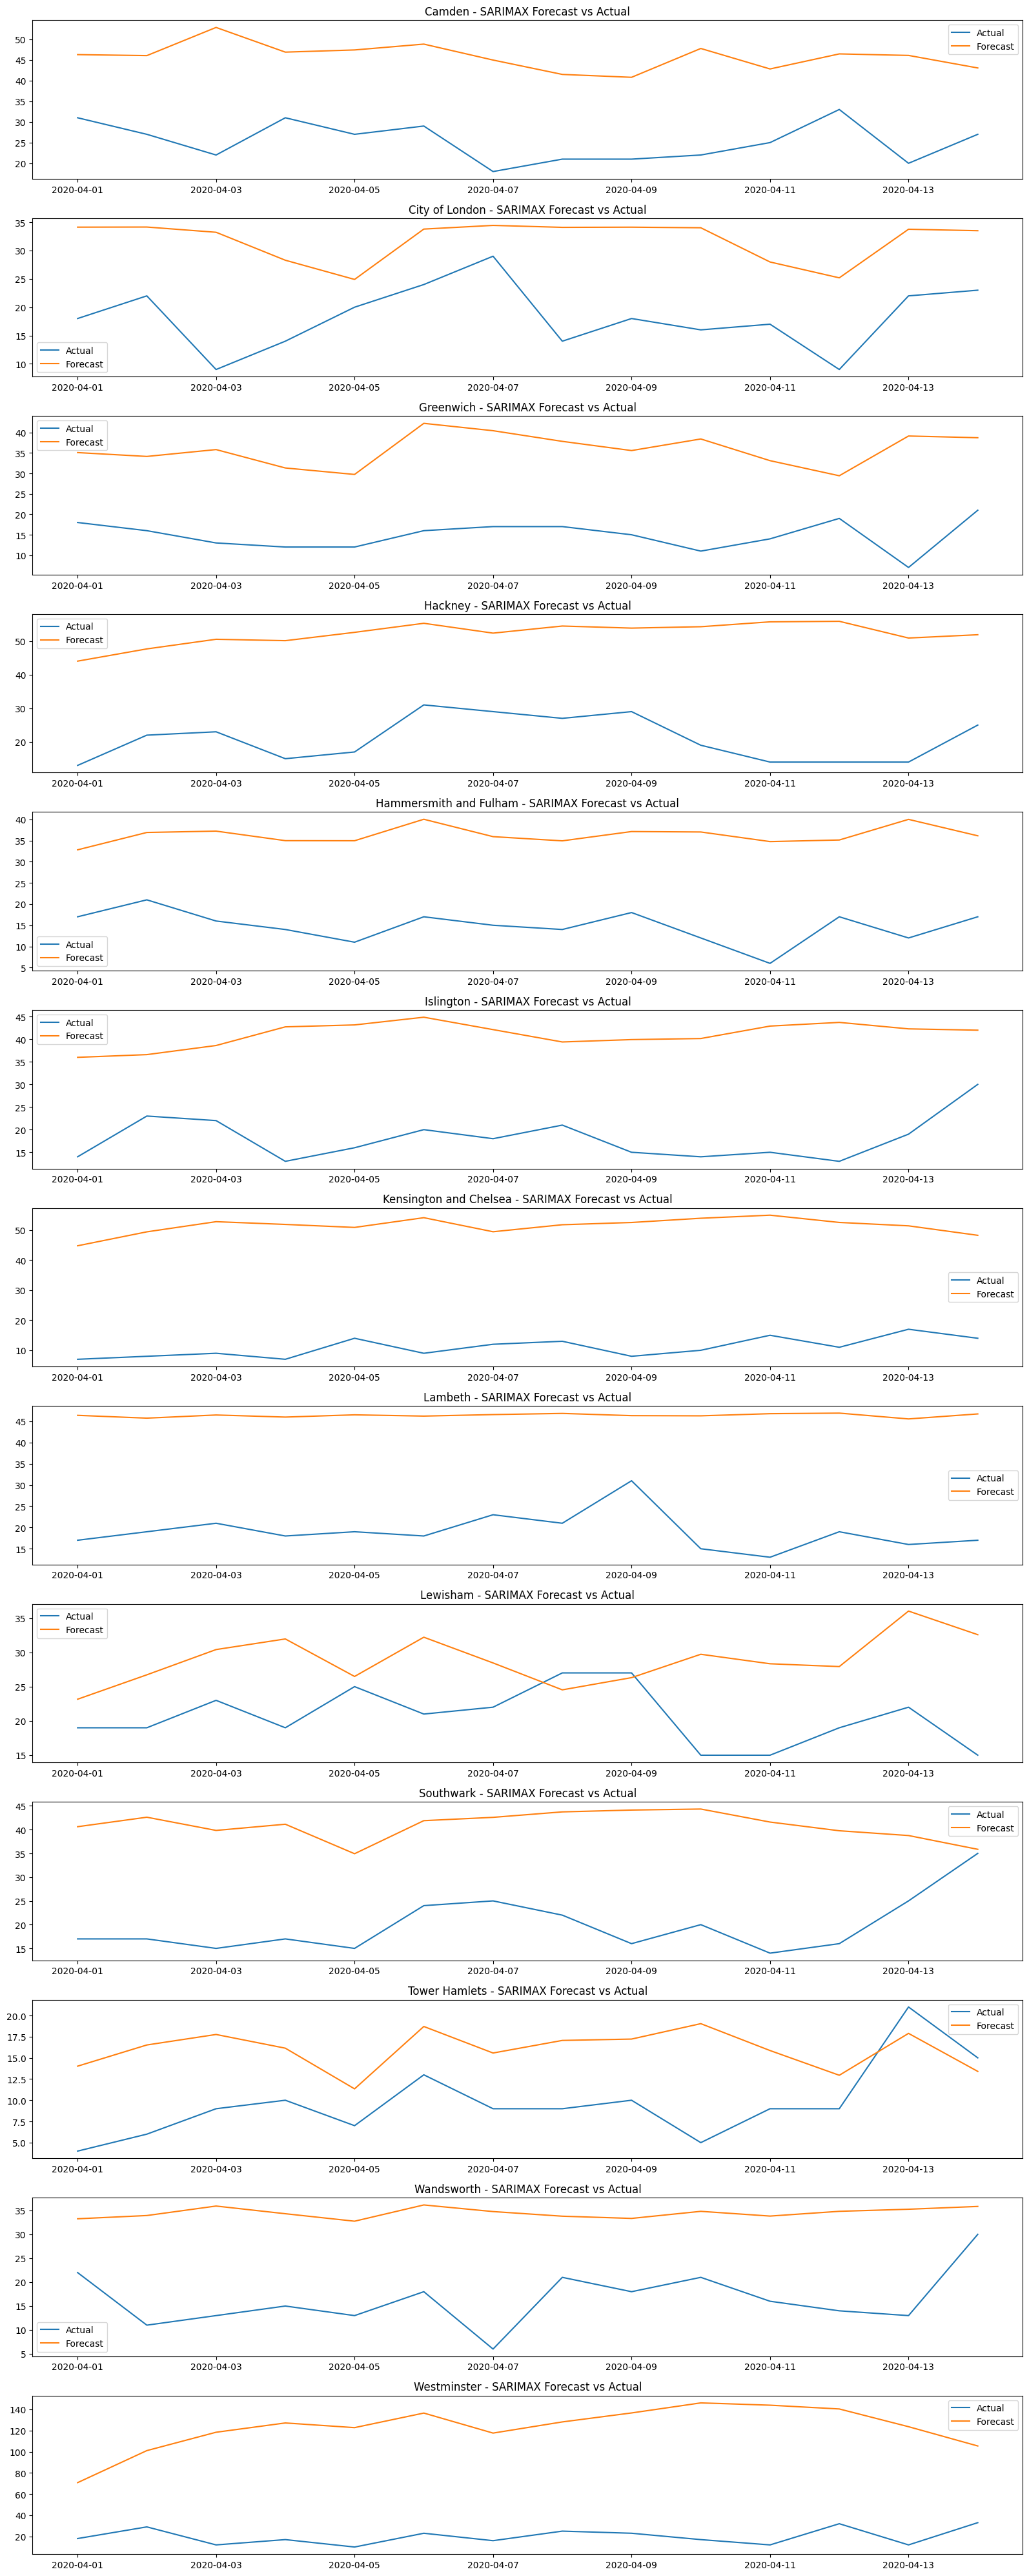

In [26]:
# Plot predictions
plt.figure(figsize=(16, 40))
for idx, record in enumerate(all_predictions):
    plt.subplot(len(all_predictions), 1, idx + 1)
    plt.plot(record["dates"], record["actual"], label="Actual")
    plt.plot(record["dates"], record["predicted"], label="Forecast")
    plt.title(f"{record['borough']} - SARIMAX Forecast vs Actual")
    plt.legend()

plt.tight_layout()
plt.show()

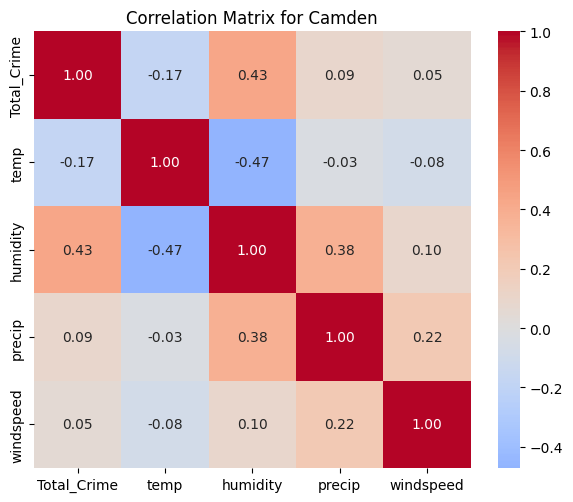

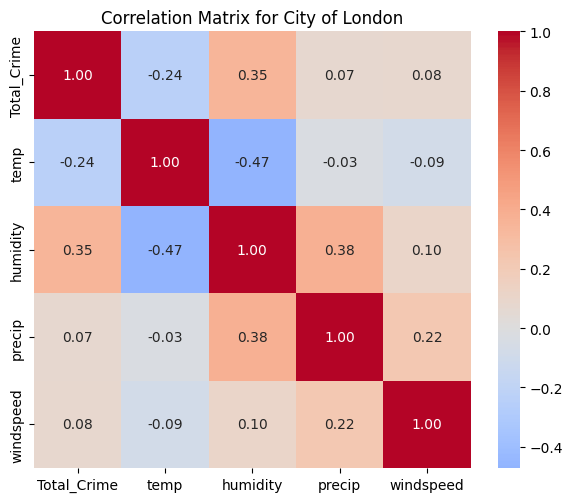

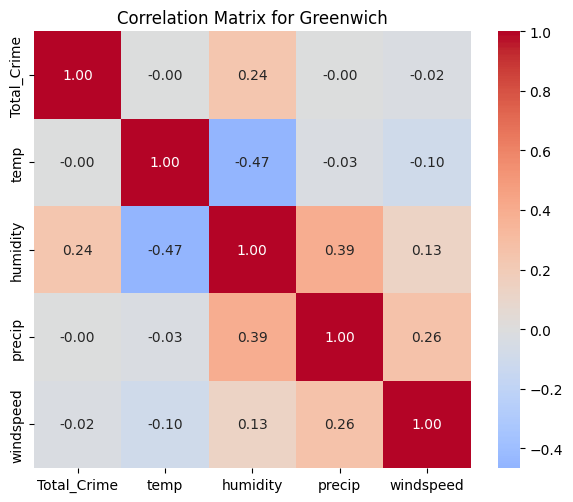

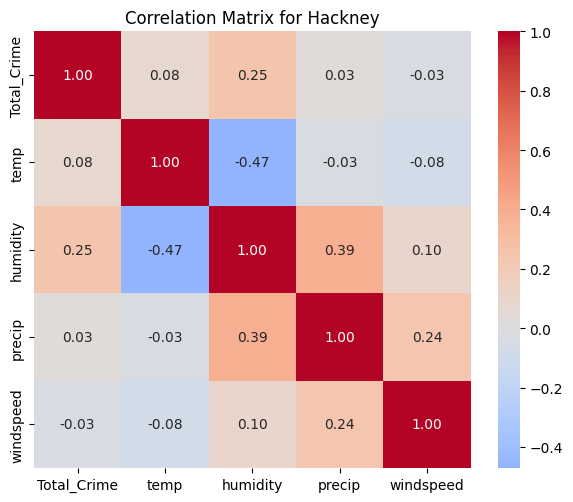

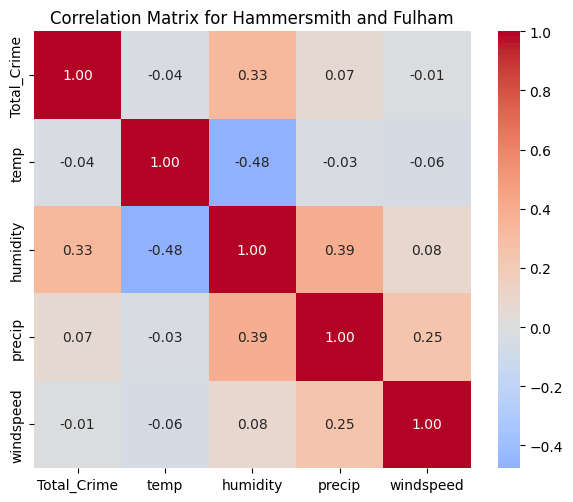

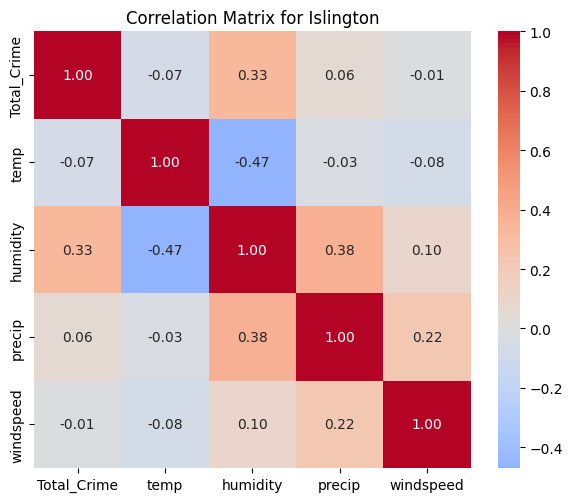

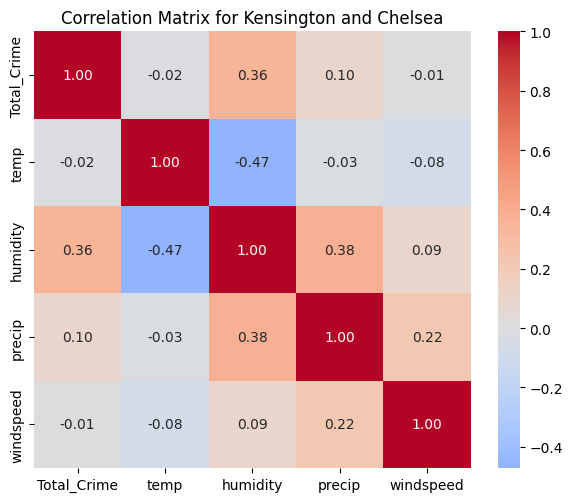

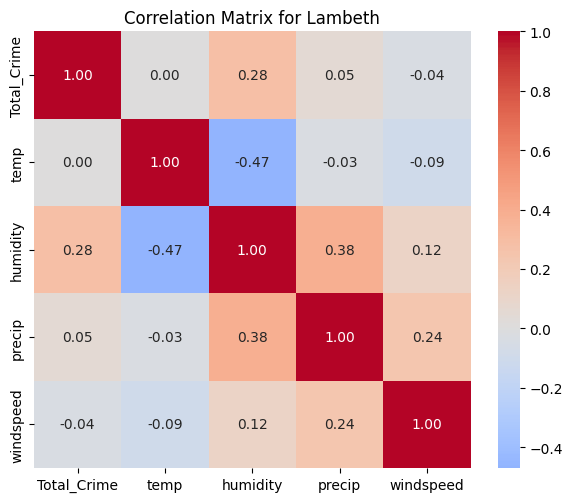

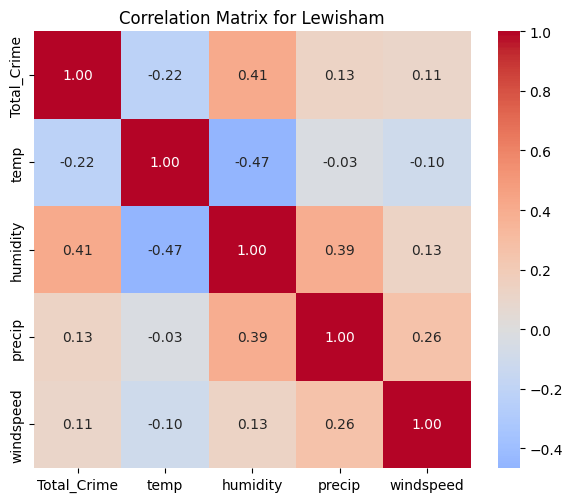

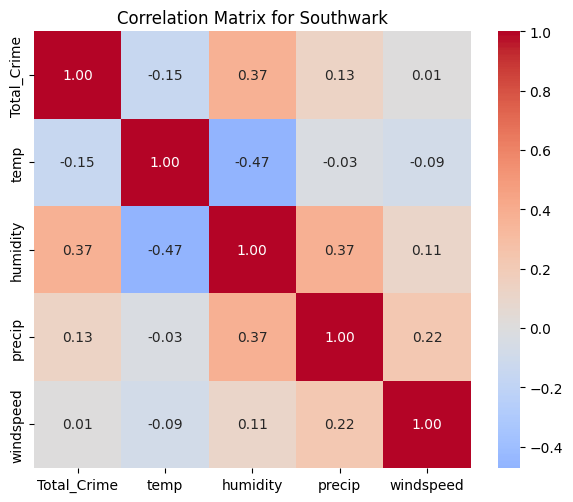

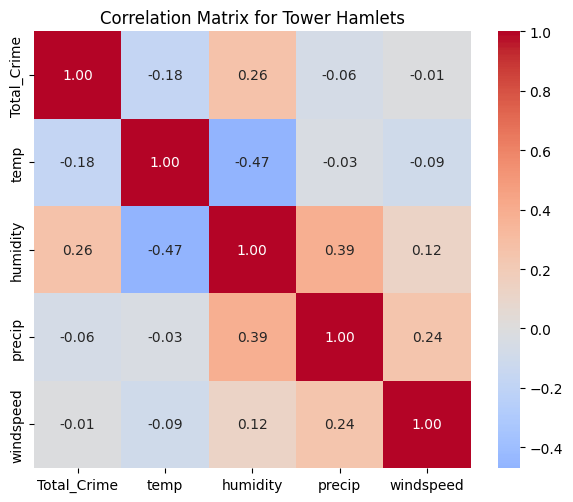

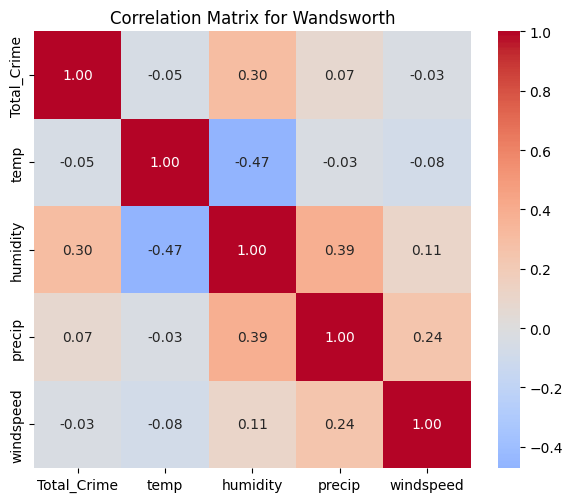

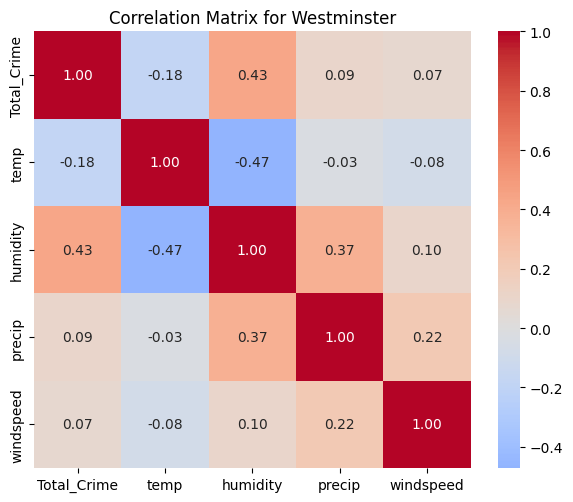

,Borough,temp_corr,humidity_corr,precip_corr,windspeed_corr
0,Camden,-0.172406,0.432690,0.088557,0.053062
1,City of London,-0.238045,0.347415,0.069824,0.084847
2,Greenwich,-0.004381,0.240695,-0.002955,-0.024403
3,Hackney,0.078753,0.252833,0.025600,-0.034779
4,Hammersmith and Fulham,-0.036240,0.329417,0.068024,-0.014419
5,Islington,-0.065637,0.329780,0.061097,-0.010395
6,Kensington and Chelsea,-0.017385,0.360429,0.098458,-0.010361
7,Lambeth,0.004618,0.284072,0.047999,-0.036250
8,Lewisham,-0.216749,0.413544,0.127855,0.107476
9,Southwark,-0.146345,0.371746,0.130483,0.010146


In [31]:
# Define the features to include
features = ["Total_Crime", "temp", "humidity", "precip", "windspeed"]

# Get list of boroughs
boroughs = df["Borough"].unique()

# Initialize list to store correlation results
correlation_summary = []

# Loop through each borough
for borough in boroughs:
    df_b = df[df["Borough"] == borough][features]
    corr_matrix = df_b.corr()

    # Plot correlation heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f", square=True)
    plt.title(f"Correlation Matrix for {borough}")
    plt.tight_layout()
    plt.show()

    # Extract correlation with Total_Crime
    crime_corrs = corr_matrix.loc["Total_Crime", ["temp", "humidity", "precip", "windspeed"]]
    correlation_summary.append({
        "Borough": borough,
        "temp_corr": crime_corrs["temp"],
        "humidity_corr": crime_corrs["humidity"],
        "precip_corr": crime_corrs["precip"],
        "windspeed_corr": crime_corrs["windspeed"]
    })

# Create summary DataFrame
correlation_df = pd.DataFrame(correlation_summary)

# Show the correlation summary table
display(correlation_df)